In [2]:
import torch
import torchvision
import warnings
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from tqdm import trange

In [16]:
#задание трансформаций для обработки данных
transform = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)
#oпределение размера пакета (batch size)
batch_size = 128

#cоздание тренировочного и тестового наборов данных
trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

num_classes = 10

Files already downloaded and verified
Files already downloaded and verified


- Предварительная обработка и подготовка данных для обучения и тестирования модели.
- Используется набор данных CIFAR-10, который загружается с помощью torchvision.datasets.CIFAR10.
- Данные проходят серию преобразований с использованием классов из torchvision.transforms (например, изменение размера изображений, преобразование в тензоры и нормализация).
- Загруженные данные разделяются на обучающую и тестовую выборки и загружаются в соответствующие DataLoader для эффективной обработки итерациями.

In [4]:
#определение устройства (CPU или GPU) для обучения модели
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
#определение функций для обучения и тестирования модели
def train(model, criterion, optimizer, num_epochs):
    for _ in trange(num_epochs):
        for _, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

In [6]:
def test(model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Accuracy on test set: {accuracy}")
    return accuracy

In [7]:
#определение моделей эксперимента и типов экспериментов
exp_models = {
    "resnet18": models.resnet18,
    "shufflenet": models.shufflenet_v2_x1_0,
    "resnet34": models.resnet34,
    "mnasnet": models.mnasnet0_5,
}

experiment_types = {
    "exp1": lambda model: list(model.children())[-1],
    "exp2": lambda model: model.children(),
}

num_epochs = 3
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
results = {}
model_params = {}

- Определяются модели и функции, необходимые для обучения и тестирования моделей.
- Определяются модели, доступные для эксперимента: resnet18, shufflenet, resnet34, mnasnet.
-Определяются типы экспериментов, которые будут выполняться над моделями: определение последнего слоя, всех слоев модели.
-Определяются функции обучения и тестирования моделей.

In [8]:
warnings.filterwarnings("ignore")

In [9]:
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [10]:
#Обучение моделей и оценка результатов
for model_name, model_fn in exp_models.items():
    for experiment_name, experiment_fn in experiment_types.items():
        print(f"Training {model_name} with {experiment_name}")

        model = model_fn(pretrained=True)

        for param in model.parameters():
            param.requires_grad = False

        if model_name == "mnasnet":
            num_ftrs = model.classifier[1].in_features
            model.classifier[1] = nn.Linear(num_ftrs, num_classes)
        else:
            num_ftrs = model.fc.in_features
            model.fc = nn.Linear(num_ftrs, num_classes)

        modified_layers = experiment_fn(model)
        if isinstance(modified_layers, nn.Linear):
            modified_layers = [modified_layers]

        for layer in modified_layers:
            for param in layer.parameters():
                param.requires_grad = True

        model.to(device)
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
        count_train_params = count_trainable_parameters(model)
        print("Trainable params:", count_train_params)
        train(model, criterion, optimizer, num_epochs=num_epochs)
        model_params[(model_name, experiment_name)] = [model, optimizer, count_train_params]
        results[(model_name, experiment_name)] = test(model)
        del model

Training resnet18 with exp1


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 118MB/s]


Trainable params: 5130


100%|██████████| 3/3 [04:29<00:00, 89.79s/it]


Accuracy on test set: 79.42
Training resnet18 with exp2
Trainable params: 11181642


100%|██████████| 3/3 [07:26<00:00, 148.71s/it]
Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth


Accuracy on test set: 94.48
Training shufflenet with exp1


100%|██████████| 8.79M/8.79M [00:00<00:00, 75.0MB/s]


Trainable params: 10250


100%|██████████| 3/3 [04:09<00:00, 83.09s/it]


Accuracy on test set: 71.54
Training shufflenet with exp2
Trainable params: 1263854


100%|██████████| 3/3 [04:36<00:00, 92.01s/it]


Accuracy on test set: 91.09
Training resnet34 with exp1


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 121MB/s]


Trainable params: 5130


100%|██████████| 3/3 [04:31<00:00, 90.42s/it]


Accuracy on test set: 81.34
Training resnet34 with exp2
Trainable params: 21289802


100%|██████████| 3/3 [11:52<00:00, 237.48s/it]


Accuracy on test set: 95.27
Training mnasnet with exp1


Downloading: "https://download.pytorch.org/models/mnasnet0.5_top1_67.823-3ffadce67e.pth" to /root/.cache/torch/hub/checkpoints/mnasnet0.5_top1_67.823-3ffadce67e.pth
100%|██████████| 8.59M/8.59M [00:00<00:00, 75.5MB/s]


Trainable params: 12810


100%|██████████| 3/3 [04:09<00:00, 83.27s/it]


Accuracy on test set: 72.03
Training mnasnet with exp2
Trainable params: 950322


100%|██████████| 3/3 [04:56<00:00, 98.97s/it]


Accuracy on test set: 79.72


- Выполняется цикл обучения и тестирования моделей для всех комбинаций моделей и экспериментов.
- Для каждой модели и эксперимента выполняется инициализация модели, замораживание параметров и изменение последнего слоя (в случае mnasnet изменяется classifier[1], в других моделях изменяется fc).
- Параметры выбранных слоев делаются тренируемыми.
- Обучение модели выполняется с использованием функции train.
- После обучения модель проходит тестирование на тестовой выборке с использованием функции test.
- Результаты точности моделей сохраняются в словарь results и параметры моделей сохраняются в словарь model_params.
- Используется вспомогательная функция count_trainable_parameters для подсчета количества обучаемых параметров в модели.

In [11]:
print(model_params)

{('resnet18', 'exp1'): [ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu

In [12]:
warnings.filterwarnings("default")

In [13]:
print("\nResults:")
for (model_name, experiment_name), accuracy in results.items():
    print(f"{model_name} with {experiment_name} experiment: Accuracy = {accuracy}")


Results:
resnet18 with exp1 experiment: Accuracy = 79.42
resnet18 with exp2 experiment: Accuracy = 94.48
shufflenet with exp1 experiment: Accuracy = 71.54
shufflenet with exp2 experiment: Accuracy = 91.09
resnet34 with exp1 experiment: Accuracy = 81.34
resnet34 with exp2 experiment: Accuracy = 95.27
mnasnet with exp1 experiment: Accuracy = 72.03
mnasnet with exp2 experiment: Accuracy = 79.72


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
results[("practice1_value", "exp")] = 84
results

{('resnet18', 'exp1'): 79.42,
 ('resnet18', 'exp2'): 94.48,
 ('shufflenet', 'exp1'): 71.54,
 ('shufflenet', 'exp2'): 91.09,
 ('resnet34', 'exp1'): 81.34,
 ('resnet34', 'exp2'): 95.27,
 ('mnasnet', 'exp1'): 72.03,
 ('mnasnet', 'exp2'): 79.72,
 ('practice1_value', 'exp'): 84}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


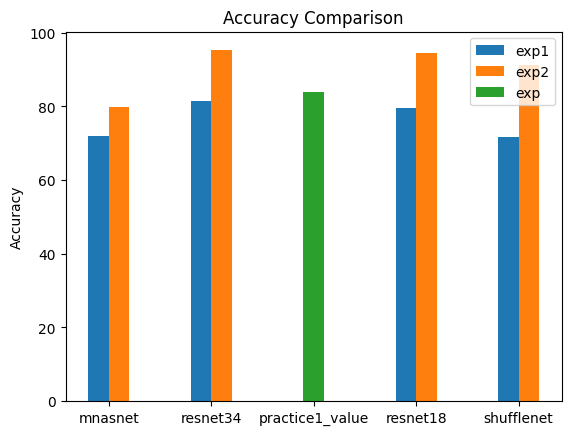

In [17]:
#визуализация результатов
practice1_value = results[("practice1_value", "exp")]
models = list({model for model, _ in results.keys()})
experiments = ["exp1", "exp2"]
num_models = len(models)
num_experiments = len(experiments)
bar_width = 0.2

accuracy_values = {model: [results.get((model, exp), 0) for exp in experiments] for model in models}

fig, ax = plt.subplots()
x = np.arange(num_models)

for i, experiment in enumerate(experiments):
    ax.bar(
        x + i * bar_width,
        [accuracy_values[model][i] for model in models],
        bar_width,
        label=experiment,
    )

ax.bar(2.1, practice1_value, bar_width, label="exp")

ax.legend(loc="upper right")

plt.title("Accuracy Comparison")
plt.xlabel("")
plt.ylabel("Accuracy")

max_accuracy = max(results.values())
plt.ylim(0, max_accuracy + 5)
plt.xticks(x + bar_width * (num_experiments - 1) / 2, models)
plt.show()